In [1]:
import pandas as pd
import numpy as np
import yfinance as Yahoo_F
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [2]:
Securities_Tickers = np.array(['COKE','^GSPC','SBUX','WMT','^FVX','AAPL','CL=F'])
YahooFinanceData = np.array([Yahoo_F.Ticker(i) for i in Securities_Tickers], dtype=object)
Historical_Price = np.array([pd.DataFrame(i.history(period='5y')) for i in YahooFinanceData], dtype=object)

In [3]:
def moving_average(Prices, moving_Avg_days, percent_above_MA, percent_below_MA, qty_toTrade):
    cash_balance = 1000000
    stock_owned = 0
    MA_values = []
    number_of_trades = 0
    days_of_trades = []
    
    for i in range(len(Prices)- int(moving_Avg_days)):
        avg_value = Prices[i:i+int(moving_Avg_days)].mean()
        MA_values.append(avg_value)
        daily_price = Prices[i+int(moving_Avg_days)]
        
        if daily_price != Prices[-1]:
            
            if daily_price >= (1+percent_above_MA) * avg_value:
                #If the stock price is above the moving average we sell the securities, only if we have enough stocks
                if stock_owned >= qty_toTrade:
                    cash_balance, stock_owned = trade(cash_balance, stock_owned, qty_toTrade, daily_price, sell=True)
                    number_of_trades += 1
                    days_of_trades.append(Prices.index[Prices == daily_price])
                else:
                    pass
                
            if daily_price <= (1-percent_below_MA) * avg_value:
                #If the stock price is below the moving average we buy the securities, only if we have enough funds
                if (qty_toTrade * daily_price) <= cash_balance:
                    cash_balance, stock_owned = trade(cash_balance,stock_owned,qty_toTrade, daily_price, buy=True)
                    number_of_trades += 1
                    days_of_trades.append(Prices.index[Prices == daily_price])
                else:
                    pass
        #We sell all the stock the last day        
        if daily_price == Prices[-1]:
            cash_balance, stock_owned = trade(cash_balance,stock_owned,stock_owned, daily_price, sell=True)
            number_of_trades += 1
            days_of_trades.append(Prices.index[Prices == daily_price])
            
    return stock_owned, int(cash_balance), MA_values, number_of_trades, days_of_trades


def trade(funds, qty_stocks_owned, qty_ToTrade, price, buy=False, sell=False):
    
    cost = price * qty_ToTrade
    if buy != sell:
        if buy is True and sell is False:
            if funds >= cost:
                cash_balance = funds - cost
                stocks_owned = qty_stocks_owned + qty_ToTrade
                return float(cash_balance), int(stocks_owned)
            else:
                return funds, qty_stocks_owned

        if sell is True and buy is False:
            if qty_stocks_owned >= qty_ToTrade:
                cash_balance = funds + cost
                stocks_owned = qty_stocks_owned - qty_ToTrade
                return float(cash_balance), int(stocks_owned)
            else:
                return funds, qty_stocks_owned

In [5]:
# Generating 40000 strategies
qty_totrade = np.arange(100).tolist() #100
days_moving_avg = [20, 50, 100, 200] #4
percent_above = np.arange (0, 1, 0.1).tolist() #10
percent_below = np.arange (0, 1, 0.1).tolist() #10

c = list(itertools.product(qty_totrade, days_moving_avg,percent_above,percent_below))
df = pd.DataFrame(c, columns = ['Quantity','MA_Days', 'Price_greater', 'Price_Lower'])

x = [] #40000 rows
for row in tqdm(df.itertuples()):
    x.append(moving_average(Historical_Price[0]['Close'], row.MA_Days,row.Price_greater,row.Price_Lower,float(row.Quantity)))

    
df['Returns'] = np.array([x[i][1] for i in range(len(x))], dtype=object)
df['MA_Values'] = np.array([x[i][2] for i in range(len(x))],dtype=object)
df['Number_Of_Trades'] = np.array([x[i][3] for i in range(len(x))],dtype=object)
df['Days_of_trades'] = np.array([x[i][4] for i in range(len(x))], dtype=object)

datatoexcel = pd.ExcelWriter('SimulationData.xlsx')
df.to_excel(datatoexcel)
datatoexcel.save()


40000it [3:19:23,  3.34it/s]  


For all strategies, the higher the quantity traded the higher the possible return for all types of Moving Averages with the 200 Moving Average yielding highest potential return. 

The average number of trades executed and the average return both increase as higher moving average types are considered in all strategies. This means that with the 200-Day Moving Average you are likely to achieve higher return  but you will do so by placing more trades than you would have placed using other Moving Average types. However, the 100-Day Moving Average has the highest Profit/Number of Trade Ratio which means that while 200-Day achieves highest average return, these returns are achieved taking more time/trades. Strategies with 50-Day SMA take more time to achieve their return than strategies with the 20 SMA take. Average Profit/Number of Trade Ratio rising from 50-day to 100-day means strategies with 50-Day SMA take more time to achieve their return than strategies with the 100 SMA take - Profit is growing with number of trades.

Strategies that bought COCA COLA stock when price was 30% less than the moving average value were able to get some returns on their trade. Only the ones using the 200-Day SMA were making considerable returns past the 30% level.However, even strategies using the 200- Day SMA stopped being profitable when the stock was bought when price was more than 40% less the moving average value.
The closer price is to the moving average the higher the average returns.

Strategies that sold COCA COLA's stock when price was more than the moving average value were able to get returns on their trades.Selling strategies' returns increased then stabilized (shorter days Moving average first) as price sold at gets higher , further away from the moving average value.
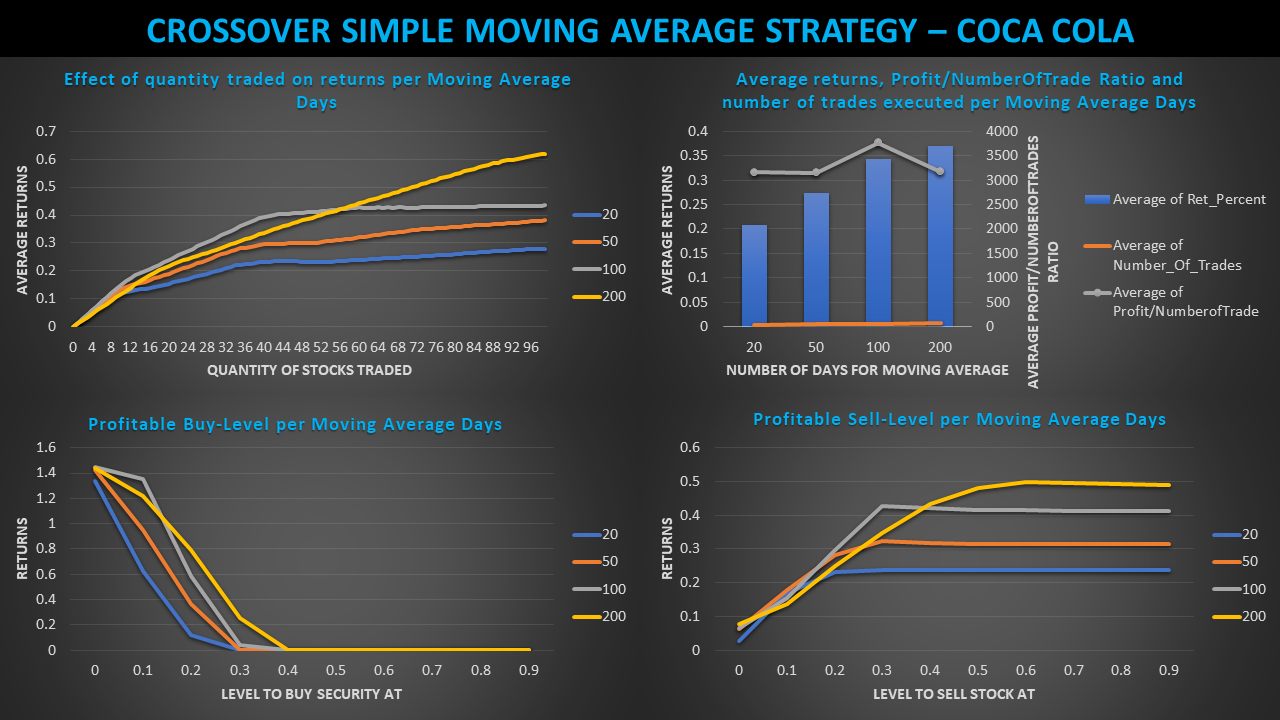


In [11]:
df.loc[df['Returns']==df['Returns'].max(),['Quantity','MA_Days','Price_greater','Price_Lower','Returns']]


,Quantity,MA_Days,Price_greater,Price_Lower,Returns
39951,99,200,0.5,0.1,4085467


With a starting income of $1000000, the strategy yielding highest returns is selling or buying 99 stocks using the 200 days SMA. Sell when price is 50 percent greater than the moving average value and buy when price is 10 percent less than the moving average value.